# TEST DATALOADER 2D DISCRETE

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from operator import itemgetter

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import fiona

import matplotlib
import matplotlib.pyplot as plt

from rasterio.enums import Resampling
import xarray

from geocube.api.core import make_geocube
from shapely.geometry import box

import json

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SequentialSampler
from torchview import draw_graph

from scipy import signal


from tqdm import tqdm
import time
import wandb
from time import sleep

# from models.load_models_2d import *
# from loss.load_losses import *
# from utils.plots_2d import *

# from dataloaders.load_2d_meteo_wtd import DiscreteDataset
from dataloaders.load_dataset import load_dataset, get_dataloader

from subprocess import Popen

dict_files = {}
with open('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/config_files_2d/concat1_time_10ep_8b.json') as f:
    dict_files = json.load(f)

print(f"Read data.json: {dict_files}")

Read data.json: {'cuda_device': 'cuda:0', 'entity': 'gsartor-unito', 'experiment_name': 'pizeo_head_2D_PINNS', 'run_name': 'concat1_time', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_2d/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_2d/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': '2d', 'piezo_head': True, 'normalization': True, 'date_max_norm': '2018-01-01', 'transform': None, 'all_dataset': True, 'max_ds_elems': 400, 'fill_val

In [3]:
import random

In [4]:
dtm_roi = rioxarray.open_rasterio(dict_files["dtm_nc"], engine='fiona')
dtm_roi = dtm_roi.rio.write_crs("epsg:4326")
dtm_roi.rio.width

1684

In [5]:
ds = load_dataset(dict_files)

timesteps = dict_files["timesteps"]

Rasterizing wtd dataframe...
Rasterized wtd dataframe.
Creating piezometric head dataset...
Piezometric head dataset created.
WTD value mean: 295.29437255859375
WTD value std: 72.11563110351562
DTM value mean: <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4172, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
DTM value std: <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(871.51434, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
Normalization: ON
Expanding values: ON


In [6]:
ds.dtm_roi_downsampled.shape

(1, 57, 84)

In [7]:
ds.wtd_numpy_mean

array(295.29437, dtype=float32)

In [8]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 8220


In [9]:
ds.wtd_data_raserized

<xarray.Dataset> Size: 362MB
Dimensions:      (y: 57, x: 84, time: 8400)
Coordinates:
  * y            (y) float64 456B 45.25 45.23 45.22 45.2 ... 44.35 44.33 44.31
  * x            (x) float64 672B 6.628 6.644 6.661 6.678 ... 7.988 8.005 8.022
  * time         (time) datetime64[ns] 67kB 2001-01-01 2001-01-02 ... 2023-12-31
    spatial_ref  int64 8B 0
Data variables:
    wtd          (time, y, x) float64 322MB nan nan nan nan ... nan nan nan nan
    wtd_mask     (time, y, x) bool 40MB False False False ... False False False

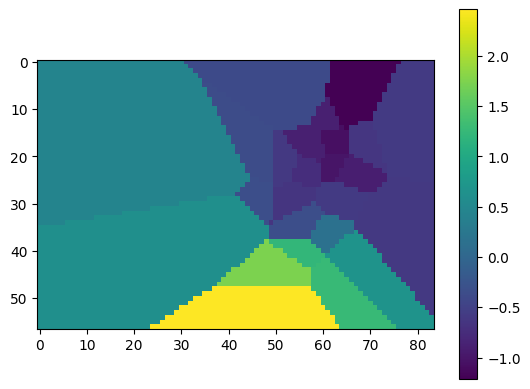

In [10]:
plt.imshow(ds.wtd_numpy[0,-1])
plt.colorbar()

In [11]:
from scipy import interpolate

In [12]:
ds.wtd_numpy.shape

(2, 8400, 57, 84)

In [18]:
for i in range(ds.wtd_numpy.shape[1]):
   data = ds.wtd_numpy[0,i]
   x = np.arange(0, data.shape[1])
   y = np.arange(0, data.shape[0])
   #mask invalid values
   array = np.ma.masked_invalid(data)
   xx, yy = np.meshgrid(x, y)
   #get only the valid values
   x1 = xx[~array.mask]
   y1 = yy[~array.mask]
   newarr = array[~array.mask]

   GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                           (xx, yy),
                              method='nearest')
   
   ds.wtd_numpy[0,i] = GD1

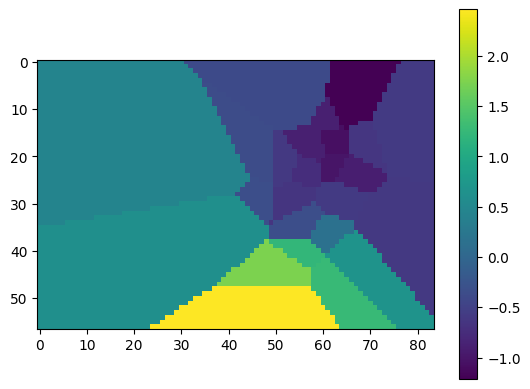

In [22]:
plt.imshow(ds.wtd_numpy[0,-1])
plt.colorbar()

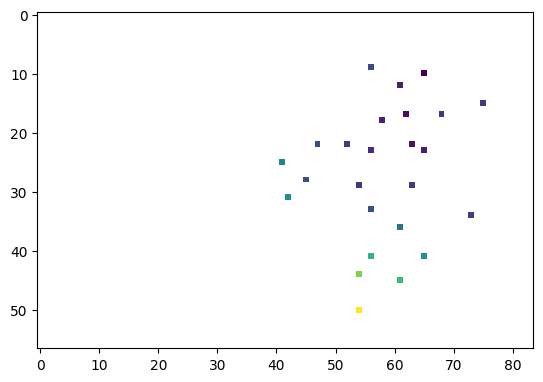

In [70]:
plt.imshow(dsds["wtd"][-1])

In [18]:
ds.wtd_data_raserized["wtd_mask"]

<xarray.DataArray 'wtd_mask' (time: 8400, y: 57, x: 84)> Size: 161MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * y            (y) float64 456B 45.25 45.23 45.22 45.2 ... 44.35 44.33 44.31
  * x            (x) float64 672B 6.628 6.644 6.661 6.678 ... 7.988 8.005 8.022
  * time         (time) datetime64[ns] 67kB 2001-01-01 2001-01-02 ... 2023-12-31
    spatial_ref  int64 8B 0

In [12]:
ds.wtd_data_raserized["wtd"].coords["x"]
# ds.wtd_data_raserized["wtd"].interp(x=x, y=y)

<xarray.DataArray 'x' (x: 84)> Size: 672B
array([6.6276, 6.6444, 6.6612, 6.678 , 6.6948, 6.7116, 6.7284, 6.7452, 6.762 ,
       6.7788, 6.7956, 6.8124, 6.8292, 6.846 , 6.8628, 6.8796, 6.8964, 6.9132,
       6.93  , 6.9468, 6.9636, 6.9804, 6.9972, 7.014 , 7.0308, 7.0476, 7.0644,
       7.0812, 7.098 , 7.1148, 7.1316, 7.1484, 7.1652, 7.182 , 7.1988, 7.2156,
       7.2324, 7.2492, 7.266 , 7.2828, 7.2996, 7.3164, 7.3332, 7.35  , 7.3668,
       7.3836, 7.4004, 7.4172, 7.434 , 7.4508, 7.4676, 7.4844, 7.5012, 7.518 ,
       7.5348, 7.5516, 7.5684, 7.5852, 7.602 , 7.6188, 7.6356, 7.6524, 7.6692,
       7.686 , 7.7028, 7.7196, 7.7364, 7.7532, 7.77  , 7.7868, 7.8036, 7.8204,
       7.8372, 7.854 , 7.8708, 7.8876, 7.9044, 7.9212, 7.938 , 7.9548, 7.9716,
       7.9884, 8.0052, 8.022 ])
Coordinates:
  * x            (x) float64 672B 6.628 6.644 6.661 6.678 ... 7.988 8.005 8.022
    spatial_ref  int64 8B 0
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [13]:
xy = list(np.ndindex(50, 50))
x = []
y = []
for (i,j) in xy:
    x.append(i)
    y.append(y)

In [ ]:
ds3 = ds.wtd_data_raserized["wtd"].interp(x=x, y=y)

: 

In [10]:
# normalization test
ds.weather_xr

<xarray.Dataset> Size: 145MB
Dimensions:      (lon: 12, lat: 9, time: 23864)
Coordinates:
  * lon          (lon) float64 96B 6.688 6.813 6.938 7.063 ... 7.813 7.938 8.063
  * lat          (lat) float64 72B 45.31 45.19 45.06 44.94 ... 44.56 44.44 44.31
  * time         (time) datetime64[ns] 191kB 1958-08-31 ... 2023-12-31
    spatial_ref  int64 8B 0
Data variables:
    prec         (time, lat, lon) float32 10MB -0.3527 -0.3534 ... -0.2029
    tmax         (time, lat, lon) float32 10MB 0.4362 0.5062 ... -0.7063 -0.5348
    tmin         (time, lat, lon) float32 10MB 0.6632 0.6891 ... -0.425 -0.4105
    tmean        (time, lat, lon) float32 10MB 0.547 0.598 ... -0.5892 -0.4867
    prain        (time, lat, lon) float32 10MB -0.3017 -0.3026 ... -0.2918 -0.16
    psnow        (time, lat, lon) float32 10MB -0.2157 -0.2157 ... -0.1528
    et_0         (time, lat, lon) float64 21MB 0.2014 0.2787 ... -1.001 -0.9348
    r_a          (time, lat, lon) float64 21MB 0.4765 0.4765 ... -1.369 -1.369
    snowpack     (time, lat, lon) float64 21MB -0.3515 -0.3515 ... -0.3511
    snowmelt     (time, lat, lon) float64 21MB -0.3119 -0.3119 ... -0.3119

In [11]:
ds.wtd_numpy.shape

(2, 8400, 57, 84)

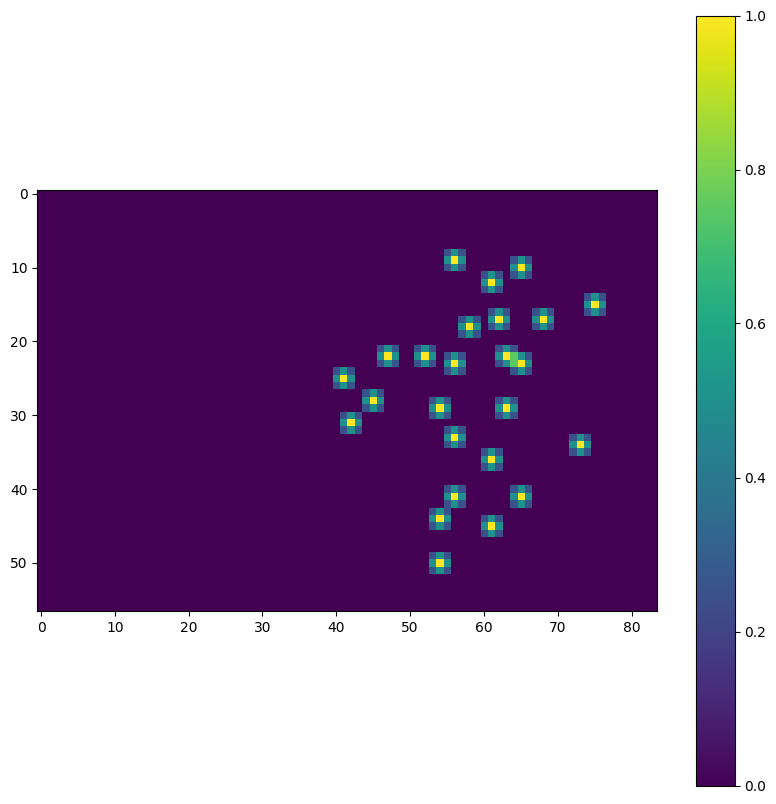

In [13]:
plt.figure(figsize = (10,10))
plt.imshow(ds.wtd_numpy[1,-10,:,:])
plt.colorbar()

In [13]:
x,y,z = ds[-1]
print(f"Sizes: {x.shape} - {y.shape} - {z.shape}")

Sizes: torch.Size([2, 57, 84]) - torch.Size([10, 180, 9, 12]) - torch.Size([2, 180, 57, 84])


In [14]:
z.dtype

torch.float32

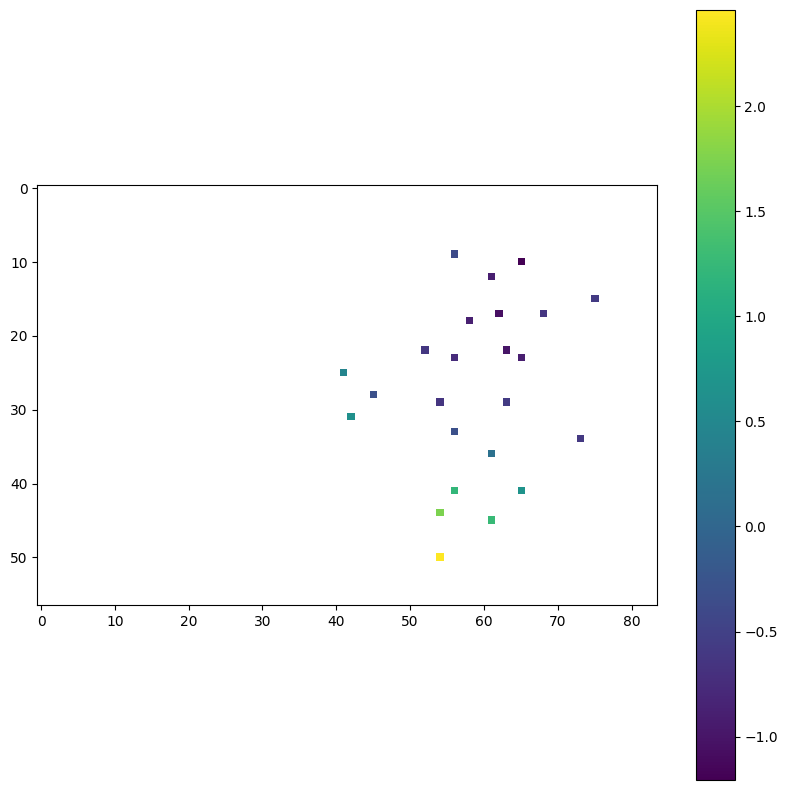

In [15]:
plt.figure(figsize = (10,10))
plt.imshow(x[0,:,:])
plt.colorbar()

/scratch_local/ipykernel_163990/3072944551.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow( (x[0,:,:] * ds.wtd_numpy_std) + ds.wtd_numpy_mean)


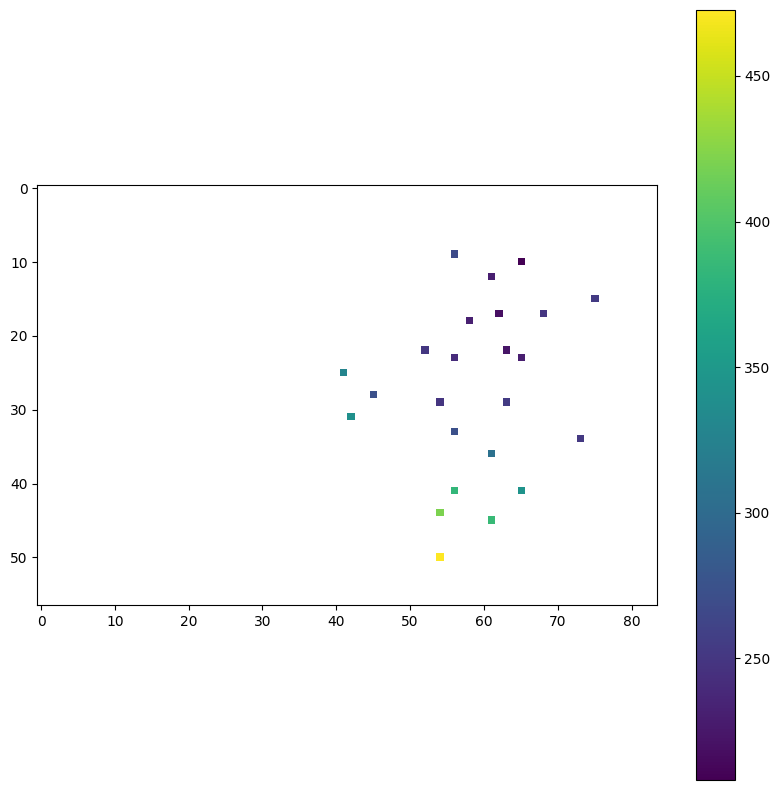

In [16]:
plt.figure(figsize = (10,10))
plt.imshow( (x[0,:,:] * ds.wtd_numpy_std) + ds.wtd_numpy_mean)
plt.colorbar()

In [17]:
x[0,:,:]

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

In [18]:
ds.dtm_roi_downsampled

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, y: 57, x: 84)> Size: 19kB
array([[[2695.4011 , 2499.1802 , 2586.5447 , ...,  195.3594 ,
          203.47043,  198.96461],
        [2322.5295 , 2262.4502 , 2304.6958 , ...,  184.70383,
          189.28033,  189.90178],
        [2082.2268 , 1886.0662 , 1840.8513 , ...,  184.88594,
          177.85524,  174.6214 ],
        ...,
        [1544.2092 , 1805.2839 , 1881.0594 , ...,  576.4552 ,
          615.05426,  670.6768 ],
        [1887.1738 , 2127.5986 , 2195.0024 , ...,  676.5523 ,
          745.30304,  780.784  ],
        [1730.4307 , 1736.7605 , 1778.5178 , ...,  662.97205,
          801.55804,  806.8966 ]]], dtype=float32)
Coordinates:
  * x            (x) float64 672B 6.635 6.651 6.668 6.685 ... 7.988 8.005 8.021
  * y            (y) float64 456B 45.26 45.24 45.22 45.21 ... 44.35 44.34 44.32
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    NETCDF_DIM_EXTRA:  {band}
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    NETCDF_DIM_band:   1
    _FillValue:        nan

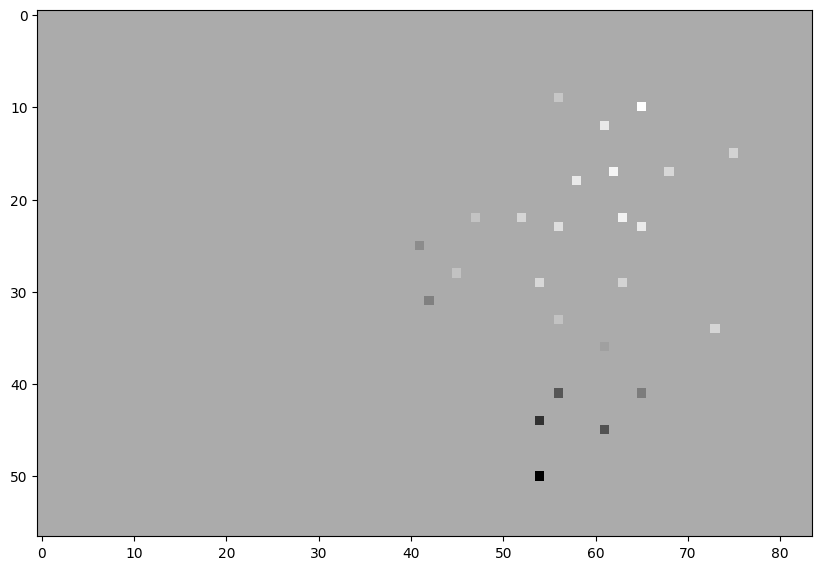

In [19]:
plt.figure(figsize = (10,10))
plt.imshow(ds.wtd_data_raserized["wtd"][-1].values, cmap="binary")

In [20]:
ds.dtm_roi_downsampled[0].shape

(57, 84)

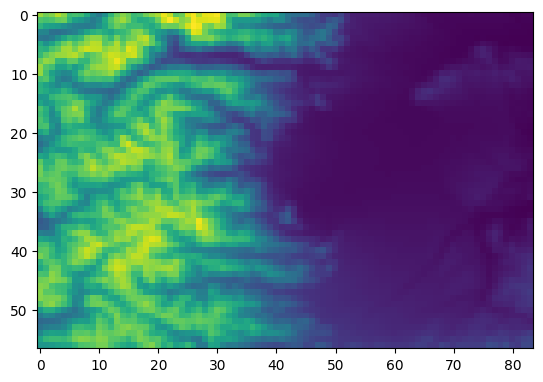

In [21]:
plt.imshow(ds.dtm_roi_downsampled[-1].values)

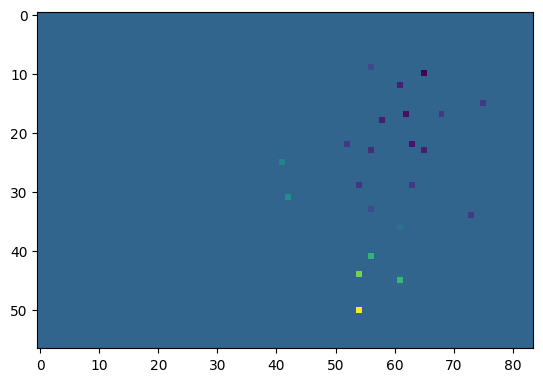

In [22]:
plt.imshow(ds.wtd_data_raserized["wtd"][-90])

In [23]:
input_mask_p = 0.1
output_mask_p = 0.1

nonzero_idxs = np.nonzero(x[:,:,1])
input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m

/scratch_local/ipykernel_539452/1532092383.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m


tensor([])

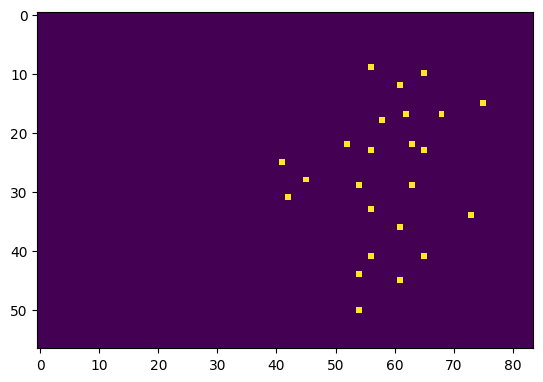

In [24]:
plt.imshow(x[1,:,:])

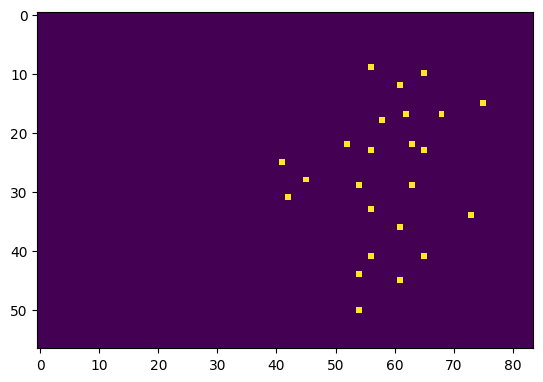

In [25]:
plt.imshow(z[-1,0,:,:])

In [26]:
ds.wtd_data_raserized["wtd"].shape

(8400, 57, 84)

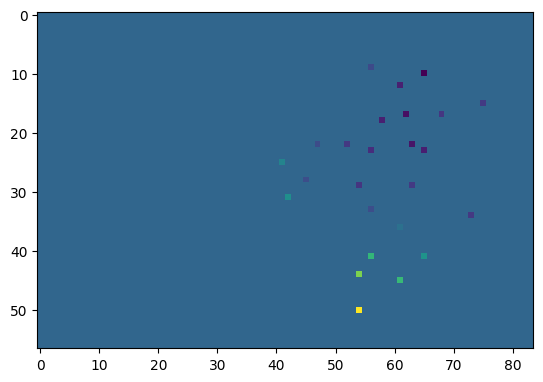

In [27]:
plt.imshow(ds.wtd_data_raserized["wtd"][-1,:,:])

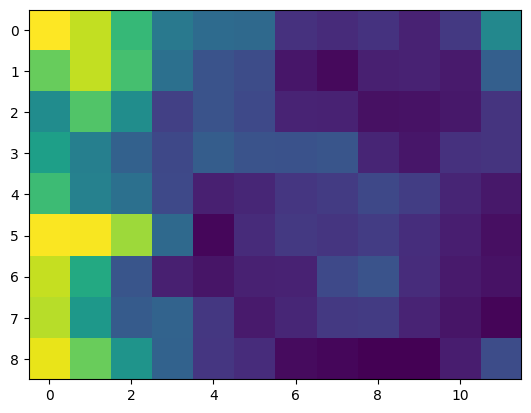

In [28]:
plt.imshow(ds.weather_xr["prec"][-1])

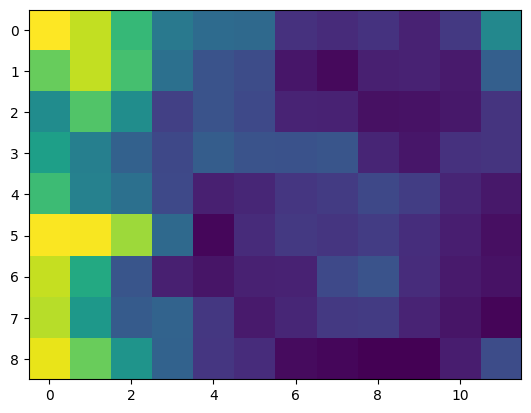

In [29]:
plt.imshow(y[0,-1,:,:])

# TEST DATALOADER

In [30]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [31]:
from models.load_model import load_model

model = load_model(dict_files).to(device)

print("Total number of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  283404


In [32]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=2,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=2,
                                            sampler=test_sampler)

Traing size: 6576, Test size: 1644


In [33]:
###### BETA ######

input_mask_p = 0.2
output_mask_p = 0.1

def apply_mask(x):
    # TODO: changed dimensions
    nonzero_idxs = np.nonzero(x[:,:,:,1])
    input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] * input_mask_m
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] * input_mask_m

###### BETA ######

In [34]:
###### BETA ######

def loss_masked_v1(y_hat,y):
    print(y_hat.shape)
    print(y.shape)
    # predict = y[:,0,:,:,:].to(device)
    predict = torch.unsqueeze(y[:,0,:,:,:], dim=1).to(device)
    target = y_hat.to(device)
    mask = y[:,1,:,:,:].bool().to(device)
    print(predict.shape)
    print(target.shape)
    print(torch.sum(mask))
    out = torch.sum((torch.masked_select(predict, mask) - torch.masked_select(target, mask))**2.0)  / torch.sum(mask)
    return out

###### BETA ######

In [35]:
dtm = torch.from_numpy(ds.dtm_roi_downsampled.values)
wtd_mean = ds.wtd_numpy_mean
wtd_std = ds.wtd_numpy_std

In [38]:
from tqdm import tqdm
import time

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X = None
X_masked = None
Y = None

model.train()
start_time = time.time()

for i in range(max_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (init_wtd, weather, pred_wtds) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")

                X = (init_wtd.to(device), weather.to(device))
                Y = model(X)
                # loss = pde_grad_loss_darcy(Y)
                loss = loss_positive_height(Y,wtd_mean,wtd_std)
                print(loss)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                
                
end_time = time.time()

Epoch 0:   0%|          | 0/3288 [00:06<?, ?batch/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [36]:
x1,y1,z1 = ds[-1]
print(f"Sizes: {x1.shape} - {y1.shape} - {z1.shape}")

Sizes: torch.Size([2, 57, 84]) - torch.Size([10, 180, 9, 12]) - torch.Size([2, 180, 57, 84])


In [37]:
model.load_state_dict(torch.load("/leonardo_scratch/fast/IscrC_DL4EO/results/discrete_2d/models/model_20250117_114653.pt", weights_only=True, map_location=torch.device('cpu')))
model.eval()

RuntimeError: Error(s) in loading state_dict for Discrete2DVanillaConcat:
	Missing key(s) in state_dict: "m_conv_f_3.case_1d_time_block.1.weight", "m_conv_f_3.case_1d_time_block.1.bias", "m_conv_f_3.case_1d_time_block.2.weight", "m_conv_f_3.case_1d_time_block.2.bias", "m_conv_f_3.case_1d_time_block.2.running_mean", "m_conv_f_3.case_1d_time_block.2.running_var", "m_conv_f_3.case_1d_time_block.5.weight", "m_conv_f_3.case_1d_time_block.5.bias", "m_conv_f_3.case_1d_time_block.6.weight", "m_conv_f_3.case_1d_time_block.6.bias", "m_conv_f_3.case_1d_time_block.6.running_mean", "m_conv_f_3.case_1d_time_block.6.running_var", "m_conv_f_3.case_1d_time_block.9.weight", "m_conv_f_3.case_1d_time_block.9.bias", "m_conv_f_3.case_1d_time_block.10.weight", "m_conv_f_3.case_1d_time_block.10.bias", "m_conv_f_3.case_1d_time_block.10.running_mean", "m_conv_f_3.case_1d_time_block.10.running_var", "m_conv_f_3.case_1d_time_block.13.weight", "m_conv_f_3.case_1d_time_block.13.bias", "m_conv_f_3.case_1d_time_block.14.weight", "m_conv_f_3.case_1d_time_block.14.bias", "m_conv_f_3.case_1d_time_block.14.running_mean", "m_conv_f_3.case_1d_time_block.14.running_var", "m_conv_f_3.case_1d_time_block.17.weight", "m_conv_f_3.case_1d_time_block.17.bias", "m_conv_f_3.case_1d_time_block.18.weight", "m_conv_f_3.case_1d_time_block.18.bias", "m_conv_f_3.case_1d_time_block.18.running_mean", "m_conv_f_3.case_1d_time_block.18.running_var", "m_conv_f_3.case_1d_time_block.21.weight", "m_conv_f_3.case_1d_time_block.21.bias". 
	size mismatch for m_conv_f_3.preproc_block.1.weight: copying a param with shape torch.Size([32, 19, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 19, 2, 3, 3]).
	size mismatch for m_conv_f_3.preproc_block.5.weight: copying a param with shape torch.Size([32, 32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 2, 3, 3]).
	size mismatch for m_conv_f_3.preproc_block.9.weight: copying a param with shape torch.Size([64, 32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 2, 3, 3]).
	size mismatch for m_conv_f_3.preproc_block.13.weight: copying a param with shape torch.Size([64, 64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 2, 3, 3]).
	size mismatch for m_conv_f_3.preproc_block.17.weight: copying a param with shape torch.Size([32, 64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 64, 2, 3, 3]).
	size mismatch for m_conv_f_3.block.1.weight: copying a param with shape torch.Size([32, 32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 2, 3, 3]).
	size mismatch for m_conv_f_3.block.5.weight: copying a param with shape torch.Size([32, 32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 2, 3, 3]).
	size mismatch for m_conv_f_3.block.9.weight: copying a param with shape torch.Size([16, 32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 32, 2, 3, 3]).
	size mismatch for m_conv_f_3.block.13.weight: copying a param with shape torch.Size([16, 16, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 2, 3, 3]).
	size mismatch for m_conv_f_3.block.17.weight: copying a param with shape torch.Size([1, 16, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 16, 2, 3, 3]).
	size mismatch for m_conv_f_3.case_1d_block.1.weight: copying a param with shape torch.Size([4, 2, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 2, 2, 3, 3]).
	size mismatch for m_conv_f_3.case_1d_block.5.weight: copying a param with shape torch.Size([8, 4, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 4, 2, 3, 3]).
	size mismatch for m_conv_f_3.case_1d_block.9.weight: copying a param with shape torch.Size([4, 8, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 8, 2, 3, 3]).
	size mismatch for m_conv_f_3.case_1d_block.13.weight: copying a param with shape torch.Size([2, 4, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([2, 4, 2, 3, 3]).
	size mismatch for m_conv_f_3.case_1d_block.17.weight: copying a param with shape torch.Size([1, 2, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 2, 2, 3, 3]).
	size mismatch for m_conv_f_3.case_1d_block.21.weight: copying a param with shape torch.Size([1, 1, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 1, 2, 3, 3]).

In [38]:
X = (torch.unsqueeze(x1, dim=0).to(device), dtm.to(device), torch.unsqueeze(y1, dim=0).to(device))
Y_hat = model(X).detach().numpy()
Y = torch.unsqueeze(z1, dim=0)

In [39]:
Y[:,0,:,:,:] = (Y[:,0,:,:,:] * wtd_std) + wtd_mean
Y_hat = (Y_hat * wtd_std) + wtd_mean

/scratch_local/ipykernel_2124567/332300776.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Y[:,0,:,:,:] = (Y[:,0,:,:,:] * wtd_std) + wtd_mean


In [40]:
def plot_random_station_time_series(y, y_hat, i, save_dir = None, model_name = None, title = None, mode = "training"):

    pz_h_mask = y[0,1,0,:,:]
    avail_idxs = np.argwhere(pz_h_mask)
    print(avail_idxs)
    idx_stat = random.randint(0, avail_idxs.shape[1]-1)
    coords_station = avail_idxs[:,idx_stat]

    x_y_plot = np.argwhere(y[0,1,:,coords_station[0],coords_station[1]])[0]
    y_plot = y[0,0,x_y_plot,coords_station[0],coords_station[1]]
    y_hat_plot = y_hat[0,0,:,coords_station[0],coords_station[1]]

    fig, ax = plt.subplots()
    fig.suptitle("Loss vs iterations")
    ax.plot(y_hat_plot, label = "predicted")
    ax.plot(x_y_plot, y_plot, label = "true", marker = "o")
    ax.legend()

    if title is not None:
        ax.set_title(title)

    if save_dir and model_name:
        plt.savefig(f"{save_dir}/timeseries_{model_name}_ep{i}_{mode}_{coords_station[0]}_{coords_station[1]}.png", bbox_inches = 'tight') # dpi = 400, transparent = True
        wandb.log({
                f"{mode}_timeseries_prediction" :  wandb.Image(f"{save_dir}/timeseries_{model_name}_ep{i}_{mode}_{coords_station[0]}_{coords_station[1]}.png", caption=f"Prediction series ({coords_station[0]},{coords_station[1]}) ep{i} {mode}")
            })

tensor([[ 9, 10, 12, 15, 17, 17, 18, 22, 22, 23, 23, 25, 28, 29, 29, 31, 33, 34,
         36, 41, 41, 44, 45, 50],
        [56, 65, 61, 75, 62, 68, 58, 52, 63, 56, 65, 41, 45, 54, 63, 42, 56, 73,
         61, 56, 65, 54, 61, 54]])


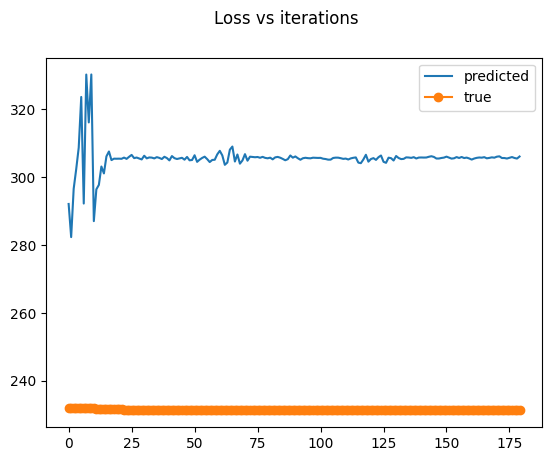

In [62]:
plot_random_station_time_series(Y, Y_hat, 0)

In [3]:
from models.load_models_2d import ConvLSTMBlock

in_channels = 1
num_features = 1

lstm_block = ConvLSTMBlock(in_channels, 1)
x_tmp = torch.ones((1,in_channels,180,50,80))

In [4]:
y_tmp = lstm_block(x_tmp)
y_tmp.shape

torch.Size([1, 1, 180, 50, 80])